**Step 1: Setting up PySpark in Colab**

Installing PySpark and Java (required for Spark to run):

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.3.0/spark-3.3.0-bin-hadoop3.tgz
!tar xf spark-3.3.0-bin-hadoop3.tgz
!pip install -q findspark


Set up environment variables:




In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.0-bin-hadoop3"

import findspark
findspark.init()


Start a Spark session:

In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").appName("NetflixEDA").getOrCreate()


**Step 2: Uploading the Netflix Dataset**

In [4]:
from google.colab import files
uploaded = files.upload()


Saving netflix_titles.csv to netflix_titles.csv


**Step 3: Loading the Dataset into PySpark**

In [5]:
file_path = "netflix_titles.csv"

# Loading dataset into Spark DataFrame
df = spark.read.option("header", "true").option("inferSchema", "true").csv(file_path)


# Showing initial data
df.show(5)


+-------+-------+--------------------+---------------+--------------------+-------------+------------------+------------+------+---------+--------------------+--------------------+
|show_id|   type|               title|       director|                cast|      country|        date_added|release_year|rating| duration|           listed_in|         description|
+-------+-------+--------------------+---------------+--------------------+-------------+------------------+------------+------+---------+--------------------+--------------------+
|     s1|  Movie|Dick Johnson Is Dead|Kirsten Johnson|                null|United States|September 25, 2021|        2020| PG-13|   90 min|       Documentaries|As her father nea...|
|     s2|TV Show|       Blood & Water|           null|Ama Qamata, Khosi...| South Africa|September 24, 2021|        2021| TV-MA|2 Seasons|International TV ...|After crossing pa...|
|     s3|TV Show|           Ganglands|Julien Leclercq|Sami Bouajila, Tr...|         null|Septem

**Step 4: Basic EDA (Exploratory Data Analysis)**

1. View the Schema

In [18]:
#Check column names and data types:
df.printSchema()


root
 |-- show_id: string (nullable = true)
 |-- type: string (nullable = true)
 |-- title: string (nullable = true)
 |-- director: string (nullable = true)
 |-- cast: string (nullable = true)
 |-- country: string (nullable = true)
 |-- date_added: string (nullable = true)
 |-- release_year: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- duration: string (nullable = true)
 |-- listed_in: string (nullable = true)
 |-- description: string (nullable = true)



2. Basic Statistics

In [7]:
#statistical summary of numerical columns:
df.describe().show()



+-------+--------------------+-------------+---------------------------------+--------------------+--------------------+----------------+---------------+-----------------+-----------------+-------------+--------------------+--------------------+
|summary|             show_id|         type|                            title|            director|                cast|         country|     date_added|     release_year|           rating|     duration|           listed_in|         description|
+-------+--------------------+-------------+---------------------------------+--------------------+--------------------+----------------+---------------+-----------------+-----------------+-------------+--------------------+--------------------+
|  count|                8809|         8808|                             8807|                6173|                7983|            7977|           8796|             8807|             8803|         8804|                8806|                8806|
|   mean|       

3. Inspect Missing Values

In [8]:
#checking for NULL values in each column
from pyspark.sql.functions import col, sum

df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()


+-------+----+-----+--------+----+-------+----------+------------+------+--------+---------+-----------+
|show_id|type|title|director|cast|country|date_added|release_year|rating|duration|listed_in|description|
+-------+----+-----+--------+----+-------+----------+------------+------+--------+---------+-----------+
|      0|   1|    2|    2636| 826|    832|        13|           2|     6|       5|        3|          3|
+-------+----+-----+--------+----+-------+----------+------------+------+--------+---------+-----------+



Numerical columns: Replace missing values with 0.
String columns: Replace missing values with "Unknown"

In [9]:
from pyspark.sql.functions import col

# Create a dictionary to hold fill values for each column
fill_values = {}
for column, dtype in df.dtypes:
    if dtype in ['int', 'double', 'float', 'long']:  # Numerical columns
        fill_values[column] = 0
    else:  # String columns
        fill_values[column] = "Unknown"

# Replace missing values
df_filled = df.na.fill(fill_values)

# Show the cleaned dataset
df_filled.show(5)


+-------+-------+--------------------+---------------+--------------------+-------------+------------------+------------+------+---------+--------------------+--------------------+
|show_id|   type|               title|       director|                cast|      country|        date_added|release_year|rating| duration|           listed_in|         description|
+-------+-------+--------------------+---------------+--------------------+-------------+------------------+------------+------+---------+--------------------+--------------------+
|     s1|  Movie|Dick Johnson Is Dead|Kirsten Johnson|             Unknown|United States|September 25, 2021|        2020| PG-13|   90 min|       Documentaries|As her father nea...|
|     s2|TV Show|       Blood & Water|        Unknown|Ama Qamata, Khosi...| South Africa|September 24, 2021|        2021| TV-MA|2 Seasons|International TV ...|After crossing pa...|
|     s3|TV Show|           Ganglands|Julien Leclercq|Sami Bouajila, Tr...|      Unknown|Septem

In [10]:
#checking for NULL values in each column
from pyspark.sql.functions import col, sum

df_filled.select([sum(col(c).isNull().cast("int")).alias(c) for c in df_filled.columns]).show()


+-------+----+-----+--------+----+-------+----------+------------+------+--------+---------+-----------+
|show_id|type|title|director|cast|country|date_added|release_year|rating|duration|listed_in|description|
+-------+----+-----+--------+----+-------+----------+------------+------+--------+---------+-----------+
|      0|   0|    0|       0|   0|      0|         0|           0|     0|       0|        0|          0|
+-------+----+-----+--------+----+-------+----------+------------+------+--------+---------+-----------+



Count Rows and Distinct Values



In [11]:
print("Total Rows:", df_filled.count())
print("Distinct Rows:", df_filled.distinct().count())


Total Rows: 8809
Distinct Rows: 8809


Group and Analyze Categorical Columns

In [12]:
df_filled.groupBy("rating").count().show()
df_filled.groupBy("listed_in").count().show()


+--------------------+-----+
|              rating|count|
+--------------------+-----+
|    November 1, 2020|    1|
|    Shavidee Trotter|    1|
|       Adriane Lenox|    1|
|                TV-Y|  307|
|       Maury Chaykin|    1|
|                2019|    1|
|                2017|    1|
|                  UR|    3|
| Keppy Ekpenyong ...|    1|
|      Benn Northover|    1|
|Classic Movies, D...|    1|
|                  PG|  286|
|         Jide Kosoko|    1|
|               TV-MA| 3195|
|     Jowharah Jones"|    1|
|            TV-Y7-FV|    6|
|                2006|    1|
|      Itziar Aizpuru|    1|
|              84 min|    1|
|             Unknown|    6|
+--------------------+-----+
only showing top 20 rows

+--------------------+-----+
|           listed_in|count|
+--------------------+-----+
|TV Action & Adven...|    2|
|Kids' TV, TV Come...|    1|
|Dramas, Faith & S...|    1|
|Anime Series, Cri...|    1|
|Dramas, Internati...|   25|
|Reality TV, TV Co...|    2|
|              71

Top Movies by Release Year

In [13]:
df_filled.groupBy("release_year").count().orderBy("release_year", ascending=False).show()


+-----------------+-----+
|     release_year|count|
+-----------------+-----+
|          Unknown|    2|
|    United States|    1|
|    June 12, 2021|    1|
| January 15, 2021|    1|
| January 13, 2021|    1|
|December 15, 2020|    1|
|  August 13, 2020|    1|
|           40 min|    1|
|             2021|  589|
|             2020|  952|
|             2019| 1026|
|             2018| 1145|
|             2017| 1030|
|             2016|  901|
|             2015|  559|
|             2014|  352|
|             2013|  288|
|             2012|  237|
|             2011|  185|
|             2010|  193|
+-----------------+-----+
only showing top 20 rows



**Step 5: Visualizing Results**

PySpark does not provide built-in visualization, so use Matplotlib or Seaborn after converting the data to Pandas.

Visualize Top Genres


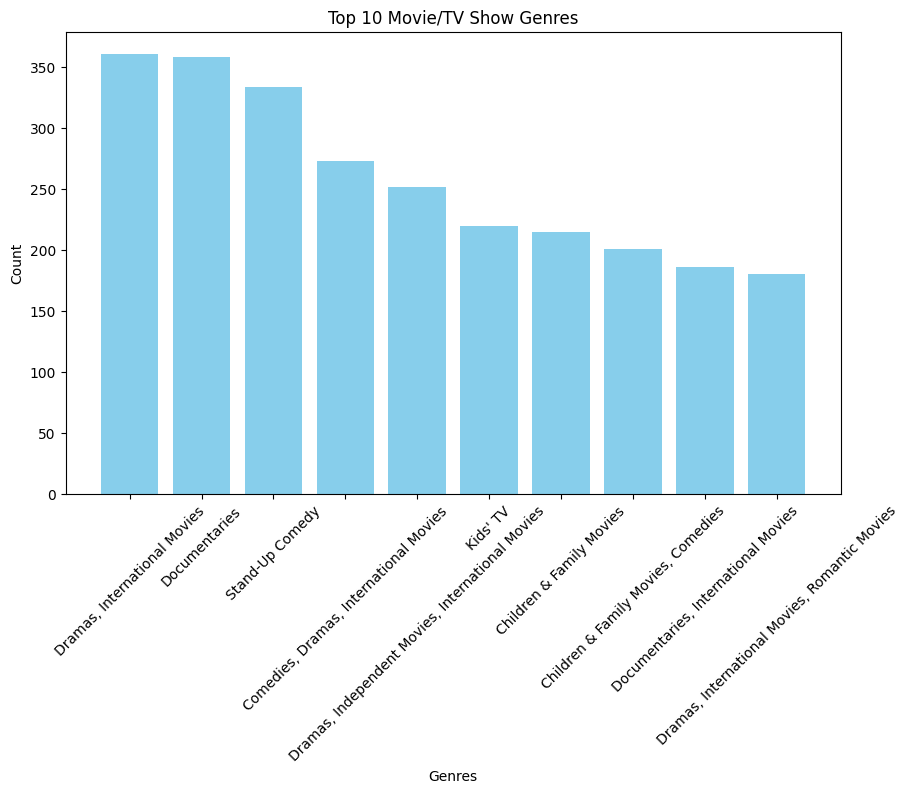

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert Spark DataFrame to Pandas DataFrame
top_genres = df_filled.groupBy("listed_in").count().orderBy("count", ascending=False).limit(10)
top_genres_pd = top_genres.toPandas()

# Plot the results
plt.figure(figsize=(10, 6))
plt.bar(top_genres_pd['listed_in'], top_genres_pd['count'], color='skyblue')
plt.xlabel("Genres")
plt.ylabel("Count")
plt.title("Top 10 Movie/TV Show Genres")
plt.xticks(rotation=45)
plt.show()


Top 10 Countries by Content Count

Bar chart showing the most active countries.

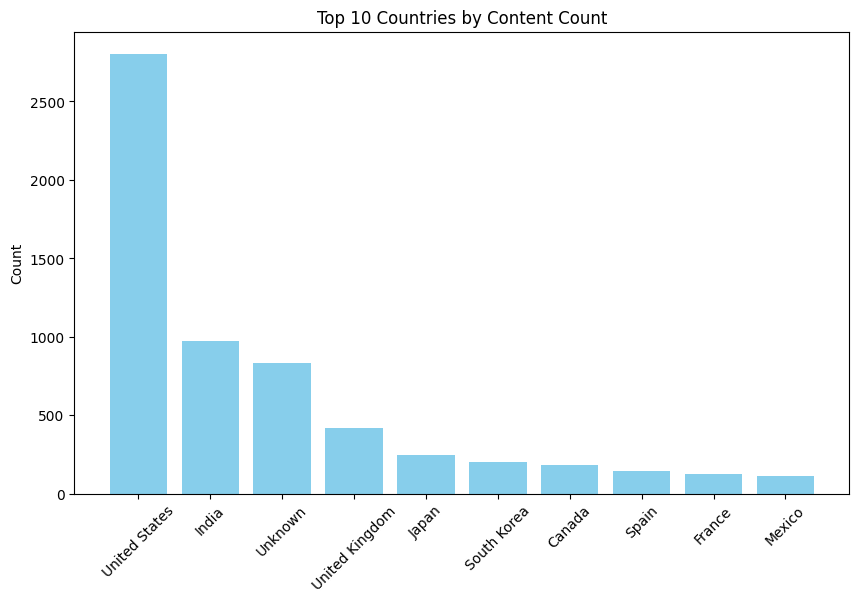

In [15]:
import matplotlib.pyplot as plt

# Group by 'country' and count the records
top_countries = df_filled.groupBy("country").count().orderBy("count", ascending=False).limit(10)
top_countries_pd = top_countries.toPandas()

# Plot
plt.figure(figsize=(10, 6))
plt.bar(top_countries_pd['country'], top_countries_pd['count'], color='skyblue')
plt.title("Top 10 Countries by Content Count")
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.show()


**Content Count by Rating**

This chart shows the number of shows/movies grouped by ratings like PG, R, etc.

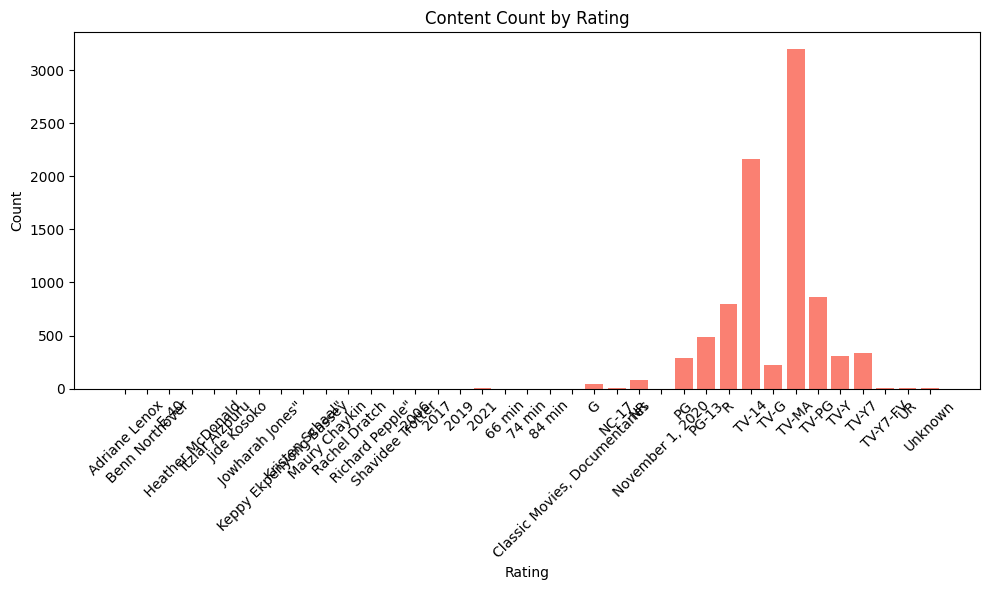

In [16]:
# Group by 'rating' and count the records
rating_counts = df_filled.groupBy("rating").count().orderBy("rating")
rating_counts_pd = rating_counts.toPandas()

# Sort the ratings alphabetically for clarity
rating_counts_pd = rating_counts_pd.sort_values(by='rating')

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(rating_counts_pd['rating'], rating_counts_pd['count'], color='salmon')
plt.title("Content Count by Rating")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


**Top 5 Years with Most Releases**

This bar chart shows only the top 5 years with the most content releases.

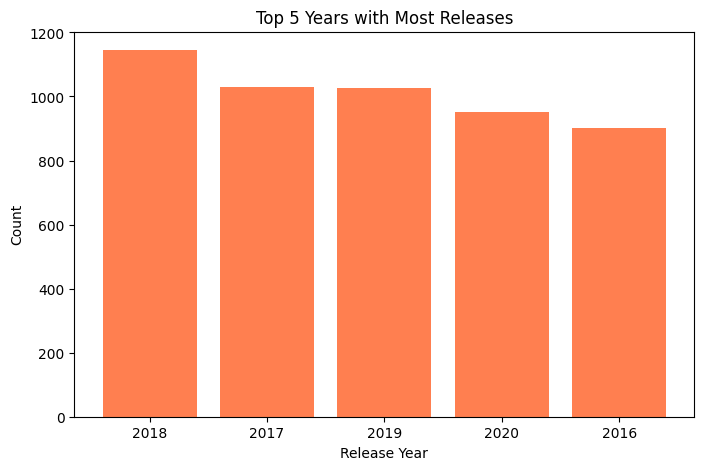

In [19]:
# Group by 'release_year', count, and select top 5 years
top_years = df_filled.groupBy("release_year").count().orderBy("count", ascending=False).limit(5)
top_years_pd = top_years.toPandas()

# Plot
plt.figure(figsize=(8, 5))
plt.bar(top_years_pd['release_year'].astype(str), top_years_pd['count'], color='coral')
plt.title("Top 5 Years with Most Releases")
plt.xlabel("Release Year")
plt.ylabel("Count")
plt.show()


In [20]:
# Saving the cleaned dataset to a CSV file
df_filled.write.csv("final_netflix_data.csv", header=True, mode="overwrite")


**EDA Summary**

Based on the analysis of the Netflix dataset:

Top Ratings: The most frequent ratings include TV-MA and PG-13, indicating a focus on mature and family content.
Top Countries: The majority of Netflix content comes from countries like United States and India.
Content Trends: The years 2018–2020 had the highest content releases, showing a recent surge in production.

In [21]:
!apt-get install git


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.11).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [26]:
!git config --global user.name "Kumalhasan2001"
!git config --global user.email "kumailhasanrizvi@gmail.com"


In [27]:
!git clone https://github.com/<Kumalhasan2001>/netflix-spark-eda.git


/bin/bash: line 1: Kumalhasan2001: No such file or directory


In [28]:
!git config --global --list


user.name=Kumalhasan2001
user.email=kumailhasanrizvi@gmail.com


In [29]:
!git clone https://github.com/Kumalhasan2001/netflix-spark-eda.git


Cloning into 'netflix-spark-eda'...
fatal: could not read Username for 'https://github.com': No such device or address


In [31]:
!ls /content


final_netflix_data.csv	sample_data		 spark-3.3.0-bin-hadoop3.tgz
netflix_titles.csv	spark-3.3.0-bin-hadoop3


In [34]:
!cp "/content/Untitled0.ipynb" "/content/netflix-spark-eda/"


cp: cannot stat '/content/Untitled0.ipynb': No such file or directory
